In [1]:
import matplotlib.pyplot as plt
import torch
from data import load_dataset_and_make_dataloaders
import utils
from model import Model1, Model2, Model22, Model3, Unet1
from fid import get_fid

gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")

In [2]:
dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=5,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

print(info)

for y, label in dl.train:
    imgs = y
    print(y.shape)
    print(label.shape)
    break

DataInfo(image_channels=1, image_size=32, num_classes=10, sigma_data=tensor(0.6623))
torch.Size([5, 1, 32, 32])
torch.Size([5])


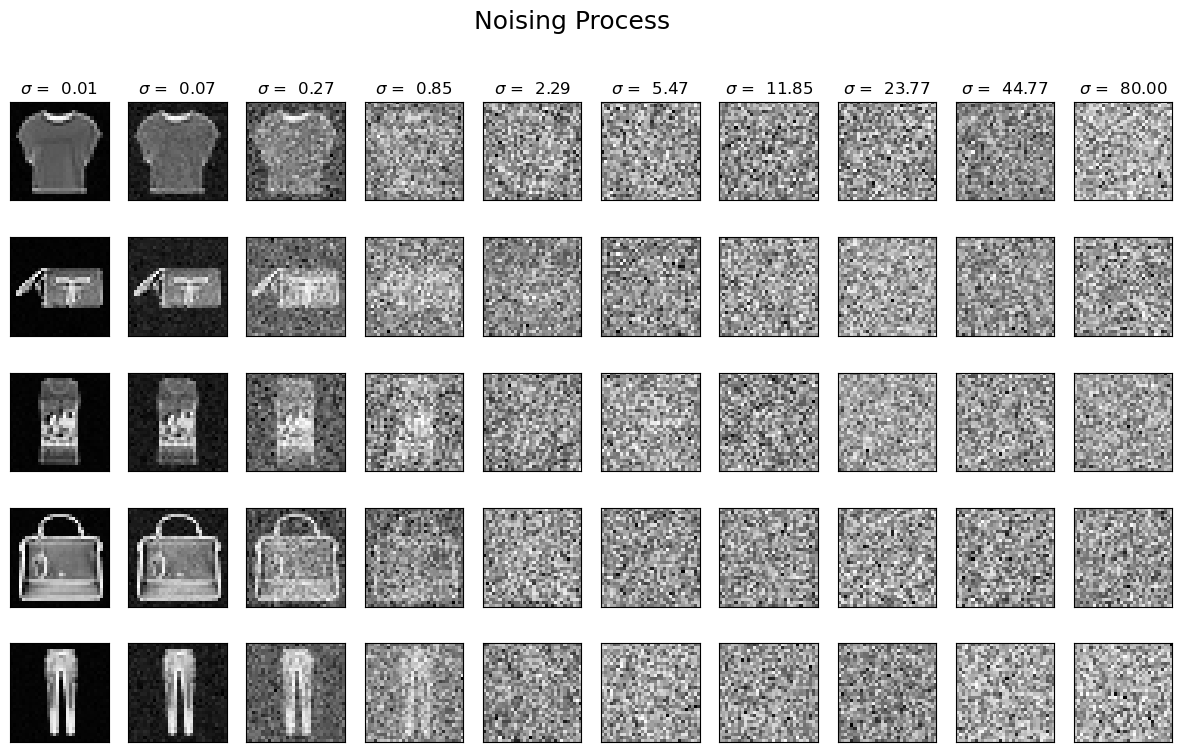

In [6]:
sigmas = utils.build_sigma_schedule(50)
noisy_imgs = utils.noising_process(imgs, sigmas)
utils.plot_imgs(noisy_imgs[::5], sigmas[::5], plot_name="noising_process", plot_title="Noising Process")

In [3]:
sigma_data = info.sigma_data.to(device)

def c_in(sigma):
    return 1. / torch.sqrt(sigma**2 + sigma_data**2)

def c_out(sigma):
    return sigma * sigma_data / torch.sqrt(sigma**2 + sigma_data**2)

def c_skip(sigma):
    return sigma_data**2 / (sigma**2 + sigma_data**2)

def c_noise(sigma):
    return torch.log(sigma) / 4.

def N(y, sigma): 
    return y + sigma * torch.randn(*y.shape, device=device)

# Model 1 - Given model, Untrained

In [6]:
model = Model1(image_channels=1, nb_channels=64, num_blocks=3, cond_channels=64).to(device)
F = model.forward

D = utils.denoiser(F, c_in, c_out, c_skip, c_noise)

FID:  459.9


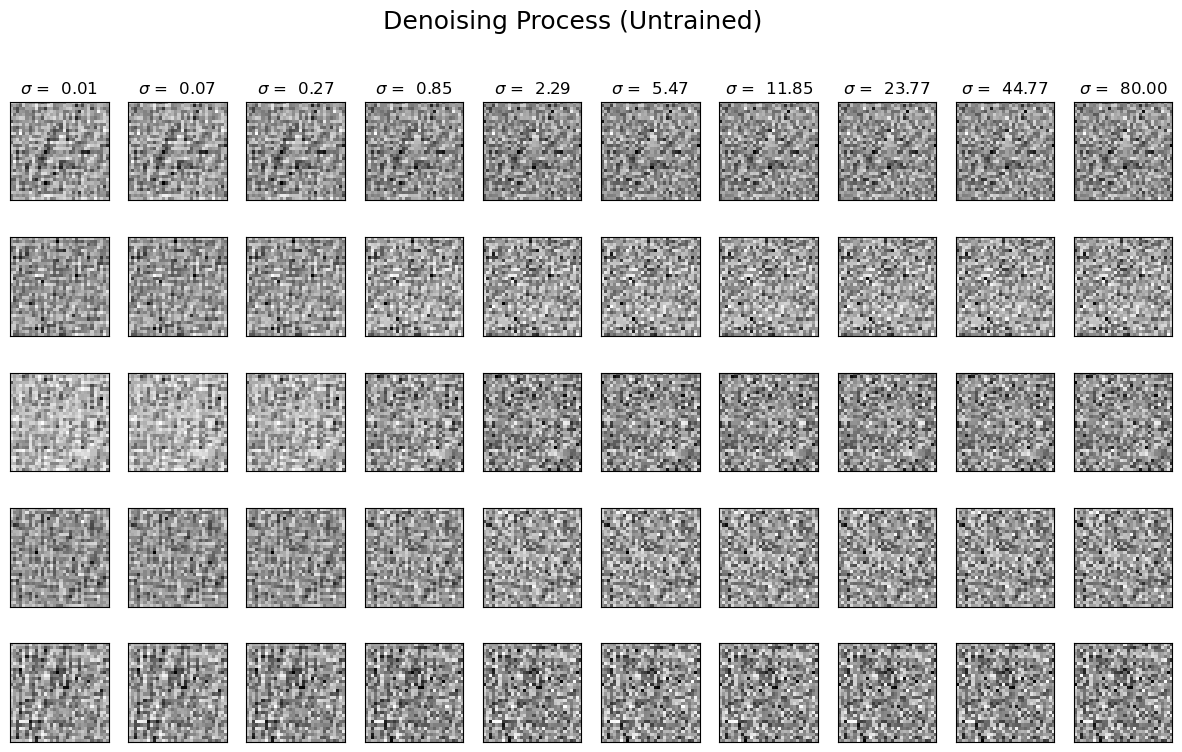

In [7]:
sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_untrained", plot_title="Denoising Process (Untrained)")

# Unet 1

In [13]:
model = Unet1(image_size=32, channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=25, lr=1e-3, batch_size=32, n_workers=6)

torch.save(model.state_dict(), f"models/unet1_channels={model.channels}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 25/25 [05:34<00:00, 13.39s/it]


# Unet 1 - 32 channels, batch size 32


FID:  139.4


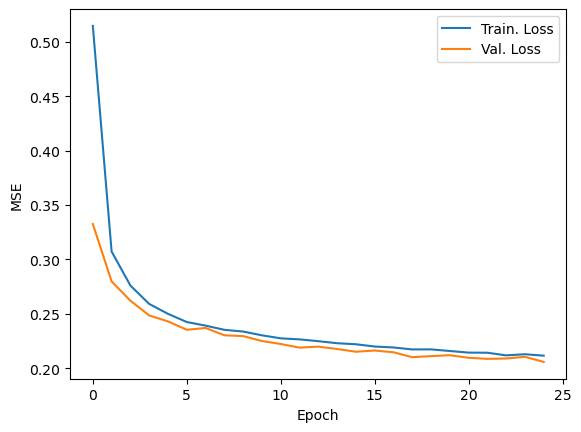

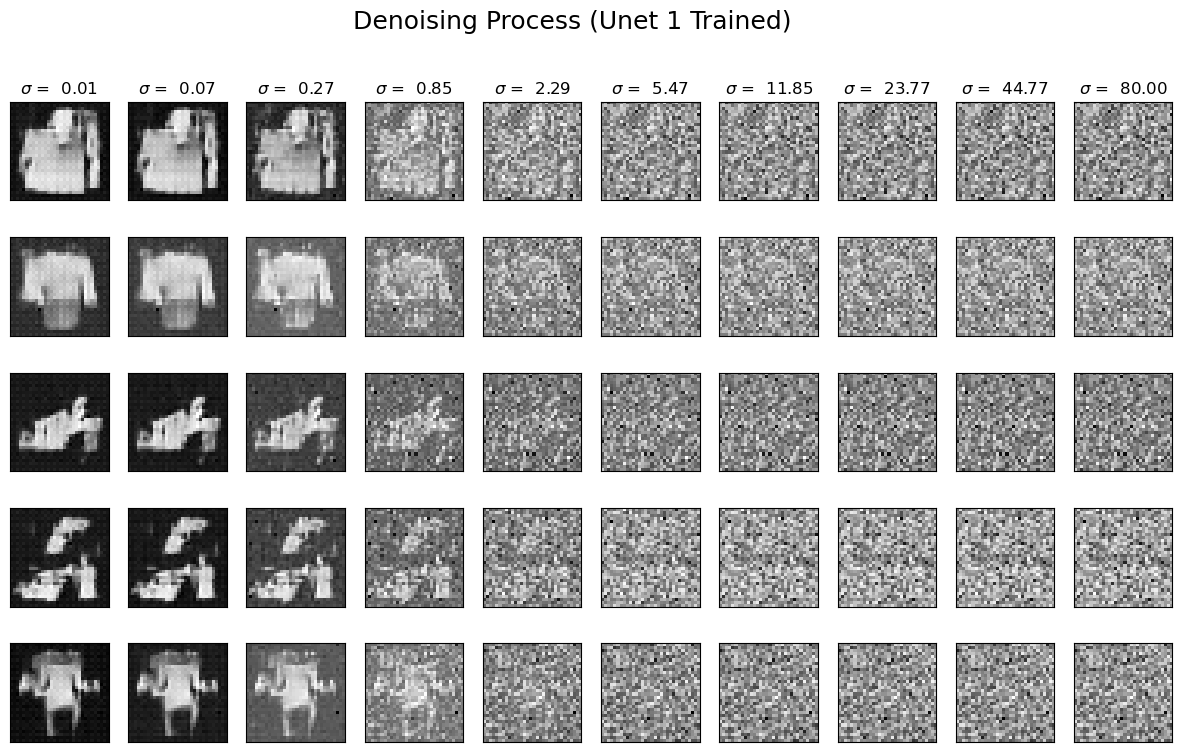

In [14]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_unet1", plot_title="Denoising Process (Unet 1 Trained)")

# Unet 1 - 32 channels, batch size 64

FID:  161.9


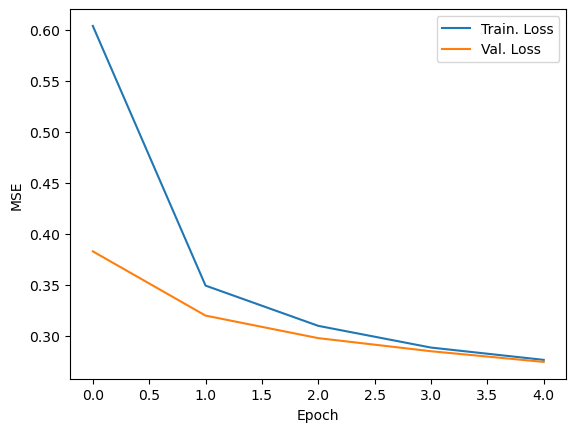

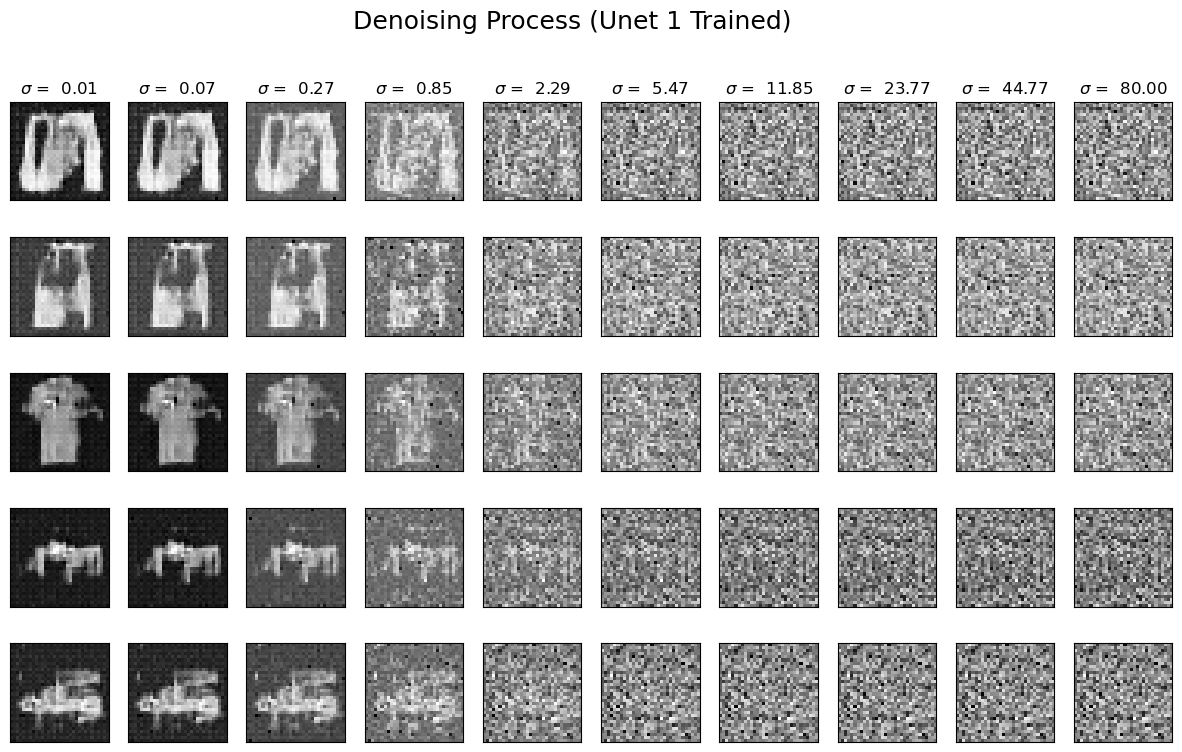

In [11]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_unet1", plot_title="Denoising Process (Unet 1 Trained)")

# Unet 1 - 64 channels, batch size 64

FID:  155.5


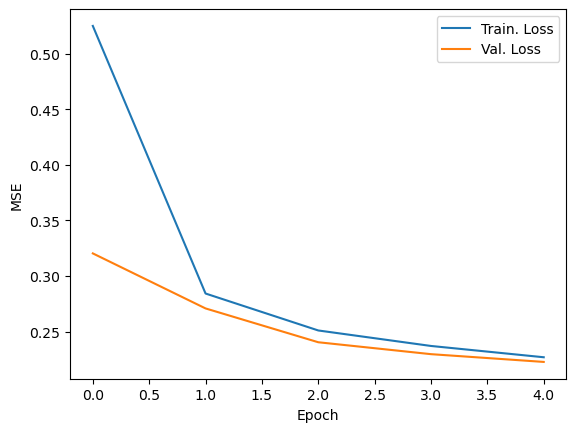

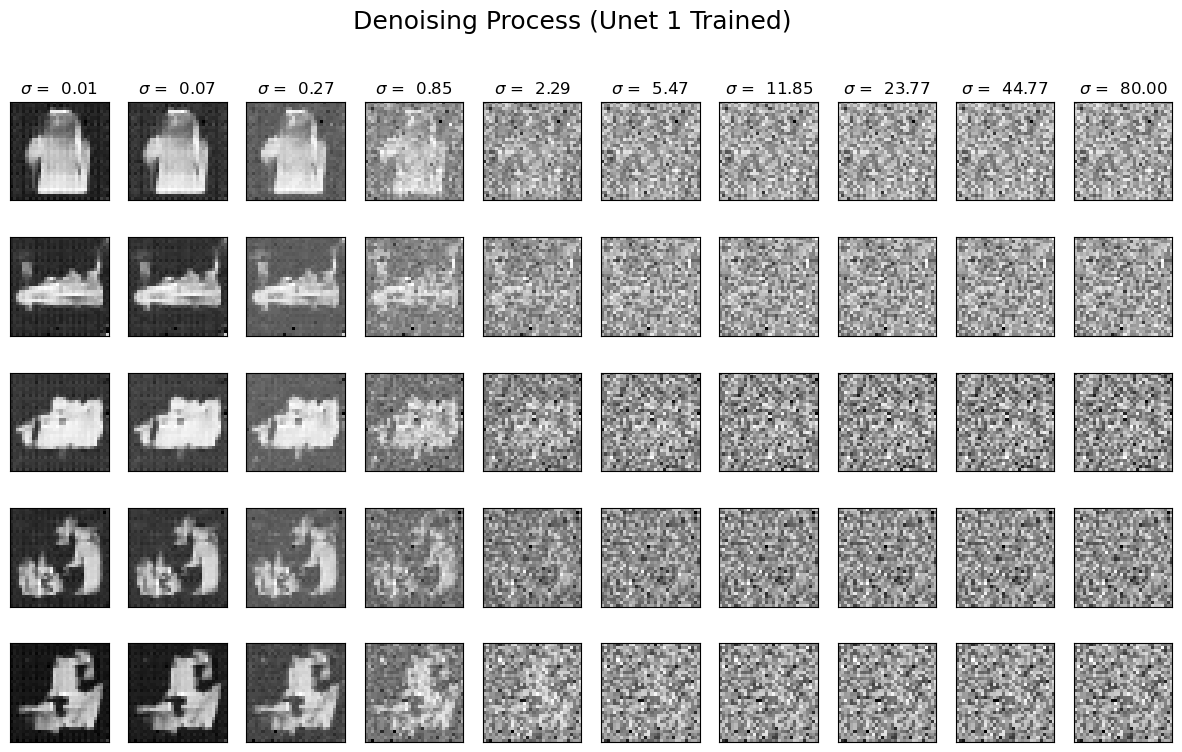

In [9]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_unet1", plot_title="Denoising Process (Unet 1 Trained)")

# Model 1 - Noise embedding not used (provided network)

In [7]:
model = Model1(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=64)

torch.save(model.state_dict(), f"models/model1_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond=64_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:18<00:00, 39.70s/it]


FID:  186.4


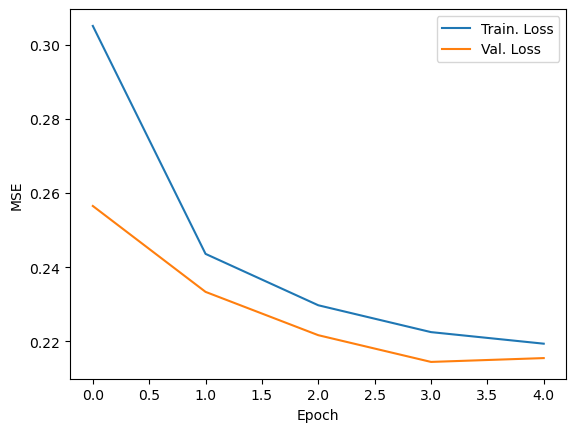

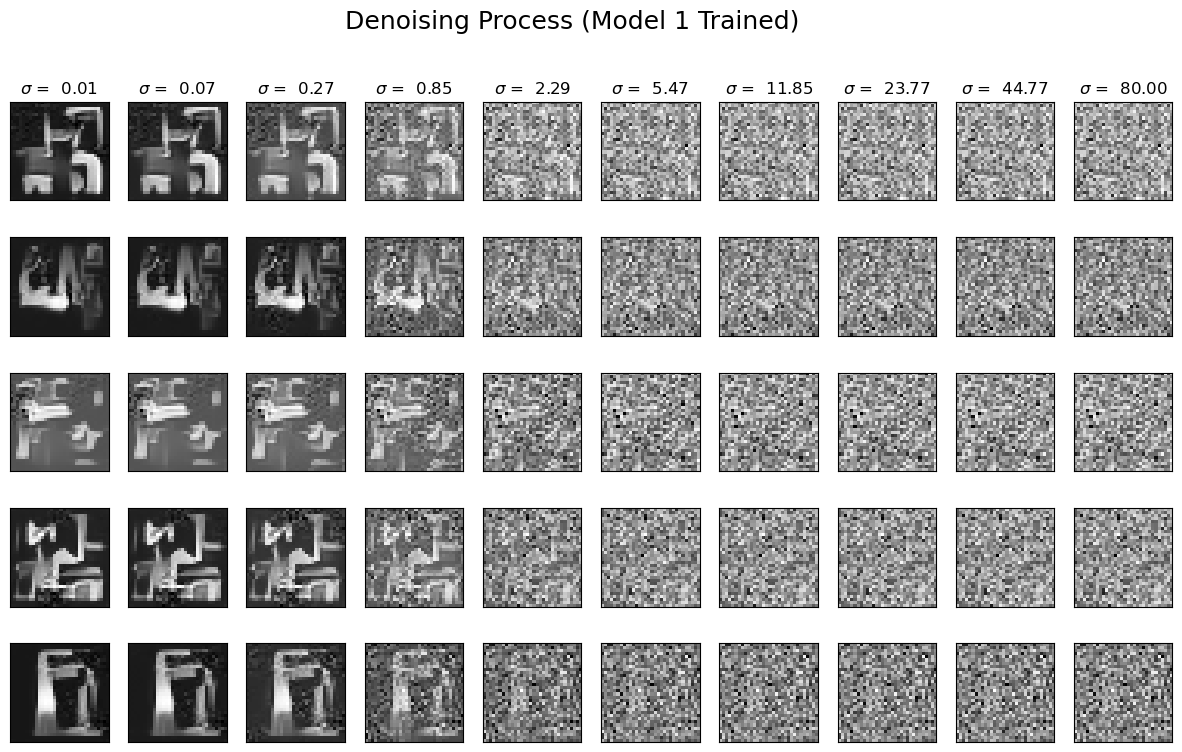

In [10]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model1", plot_title="Denoising Process (Model 1 Trained)")

# Model 2 - Noise embedding added to each Residual blocks' output 

In [11]:
model = Model2(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model2_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:42<00:00, 44.45s/it]


FID:  176.5


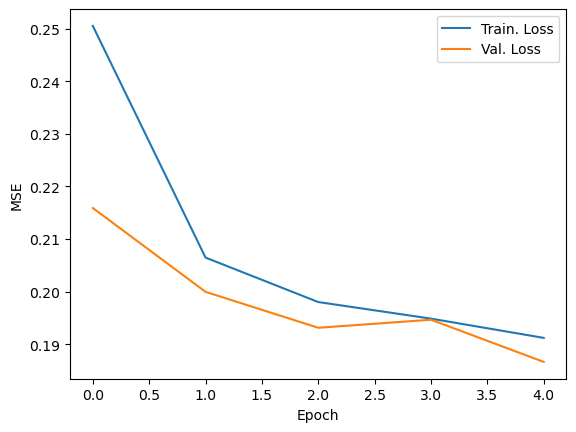

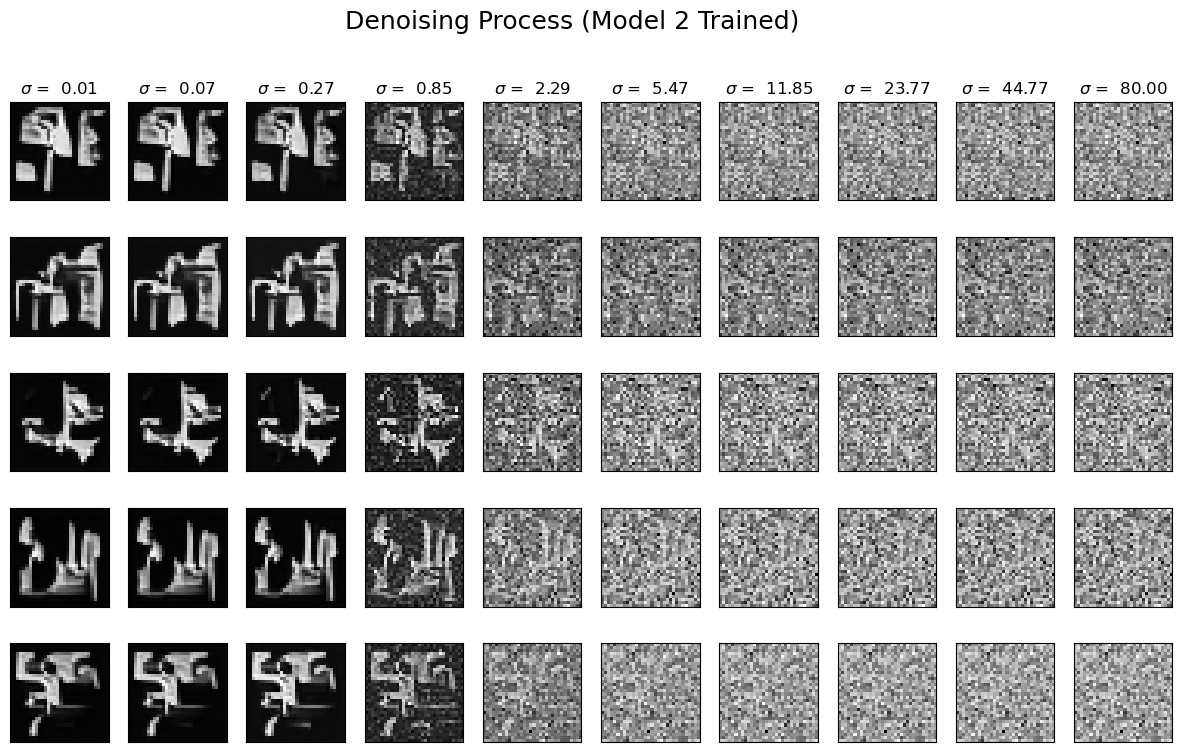

In [12]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model2", plot_title="Denoising Process (Model 2 Trained)")

# Model 22 - Noise embedding concatenated with input image

In [13]:
model = Model22(image_channels=1, image_size=32, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model22_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:42<00:00, 44.42s/it]


FID:  159.0


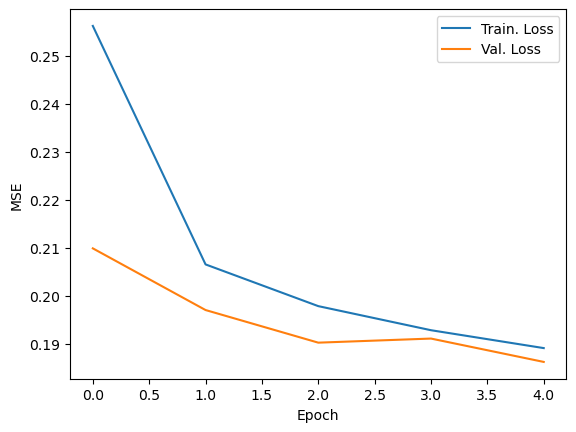

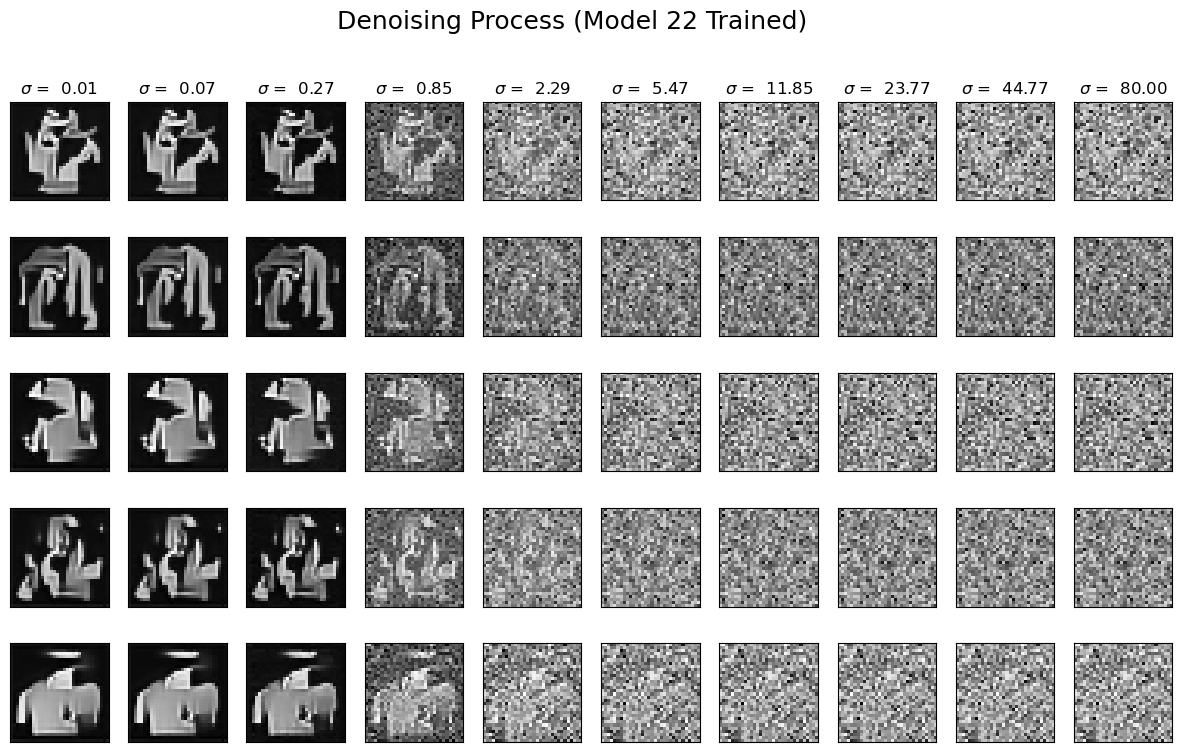

In [14]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model22", plot_title="Denoising Process (Model 22 Trained)")

# Model 22 - Same as before with conv2 and conv_out initialised to zeros

In [4]:
model = Model22(image_channels=1, image_size=32, nb_channels=32, num_blocks=3, cond_channels=32, init_zero=True).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model22_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:40<00:00, 44.14s/it]


FID:  149.4


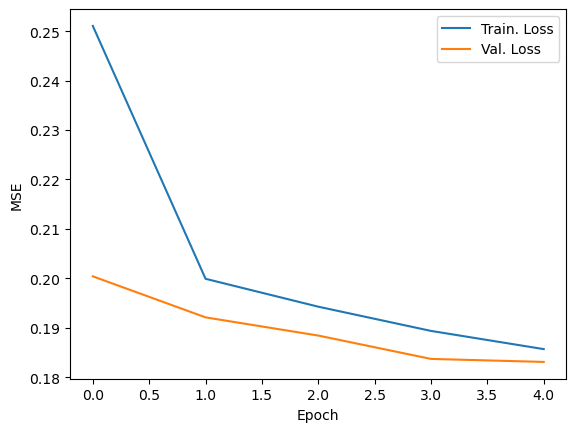

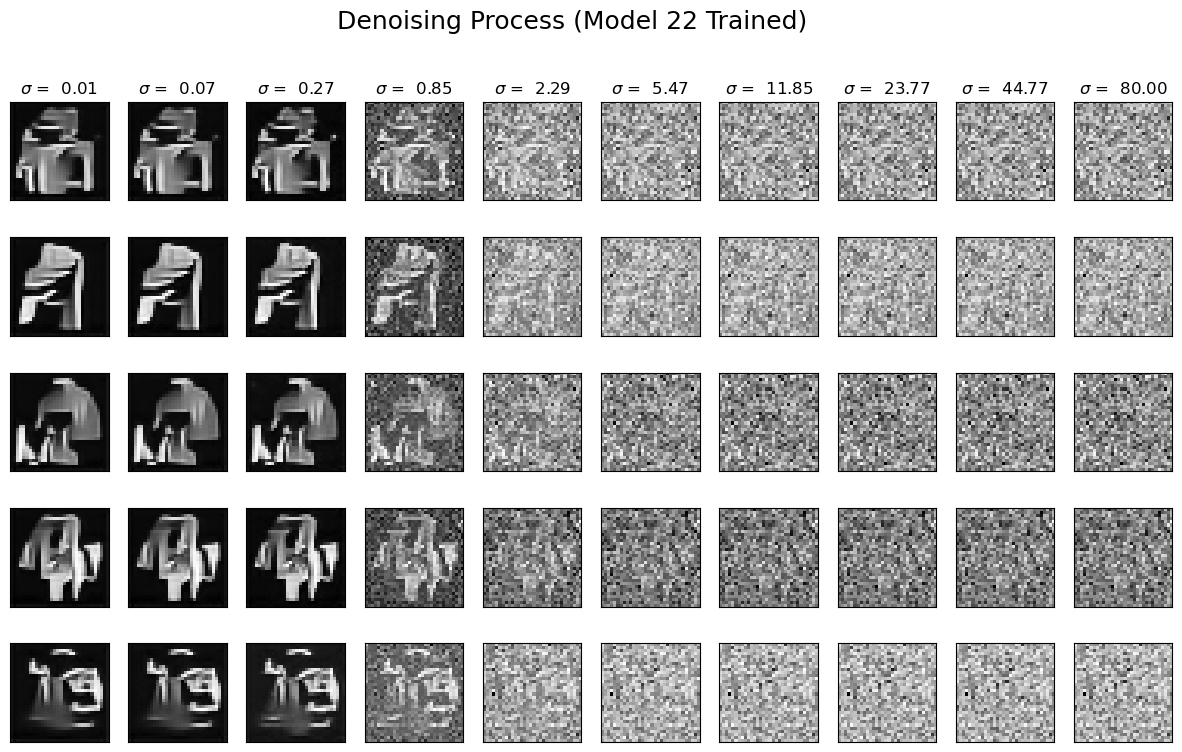

In [5]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model22", plot_title="Denoising Process (Model 22 Trained)")

# Model 3 - Noise embedding connected to Residual blocks' BatchNorm affine parameters

In [15]:
model = Model3(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model3_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:57<00:00, 47.49s/it]


FID:  168.6


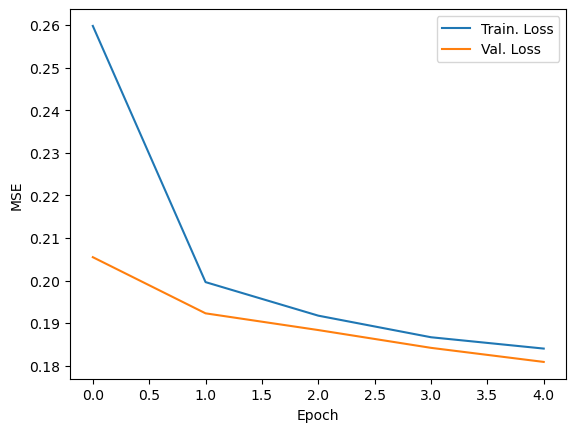

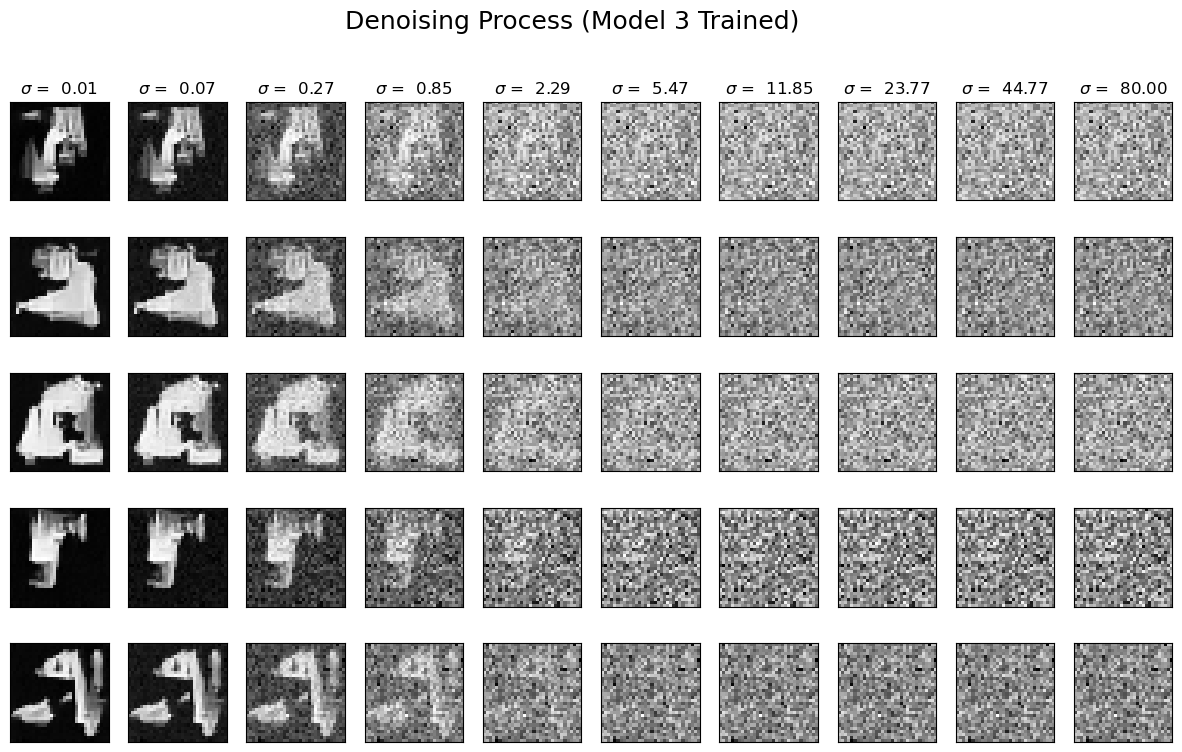

In [16]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model3", plot_title="Denoising Process (Model 3 Trained)")

# Model 3 - Same as before but with conv2 and conv_out weights initialized to zeros

In [4]:
model = Model3(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32, init_zero=True).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model3_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:54<00:00, 46.97s/it]


FID:  158.2


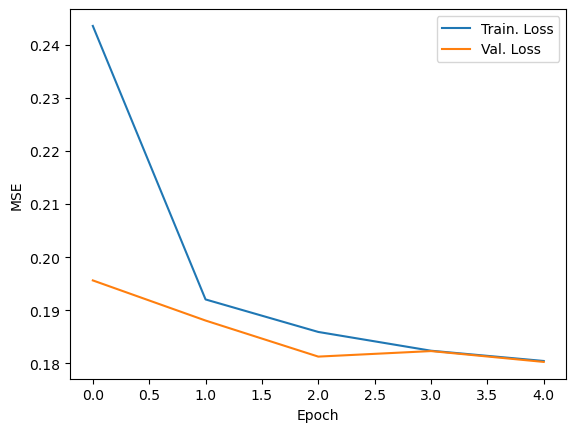

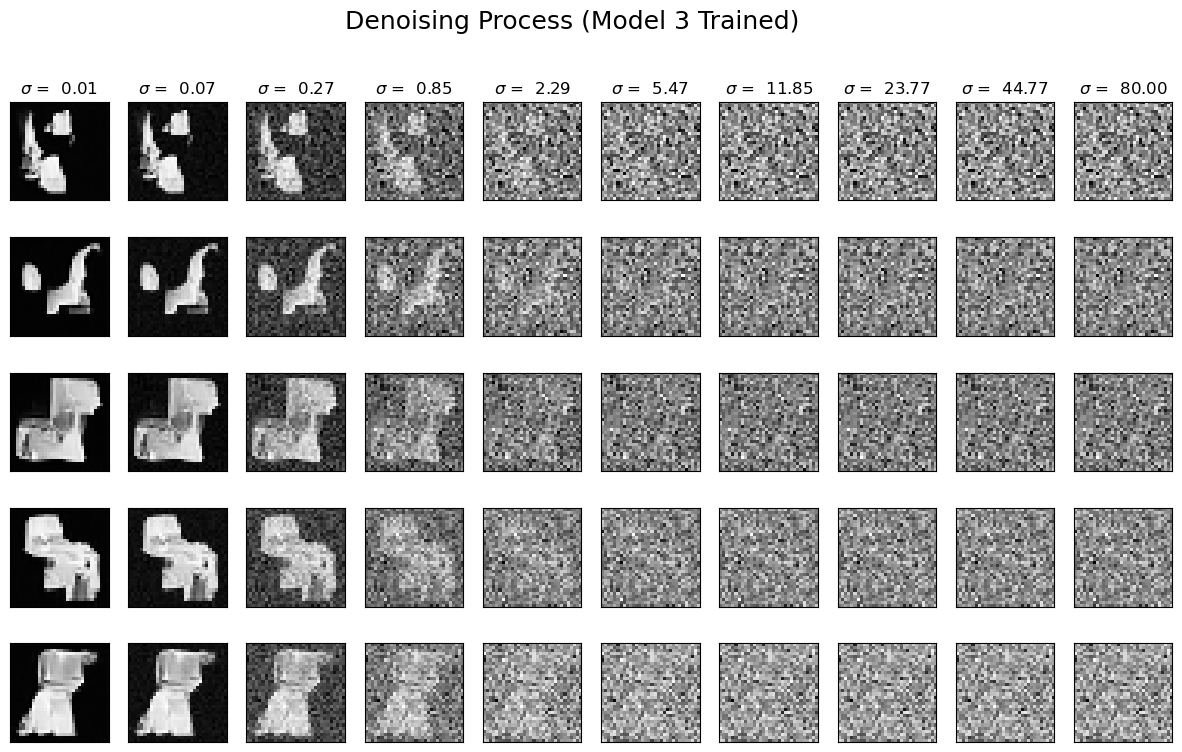

In [5]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model3", plot_title="Denoising Process (Model 3 Trained)")

# Model 3 - Except more feature channels, more blocks and longer training

In [17]:
# model = Model3(image_channels=1, nb_channels=64, num_blocks=7, cond_channels=32).to(device)

# D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=25, lr=1e-3, batch_size=32)

# torch.save(model.state_dict(), f"models/model3_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

path = "models/model3_channels=64_blocks=7_cond=32_epochs=25_lr=1e-3_bs=32"

model = Model3(image_channels=1, nb_channels=64, num_blocks=7, cond_channels=32).to(device)
model.load_state_dict(torch.load(path))
model.eval()

D = utils.denoiser(model.forward, c_in, c_out, c_skip, c_noise)

FID:  225.4


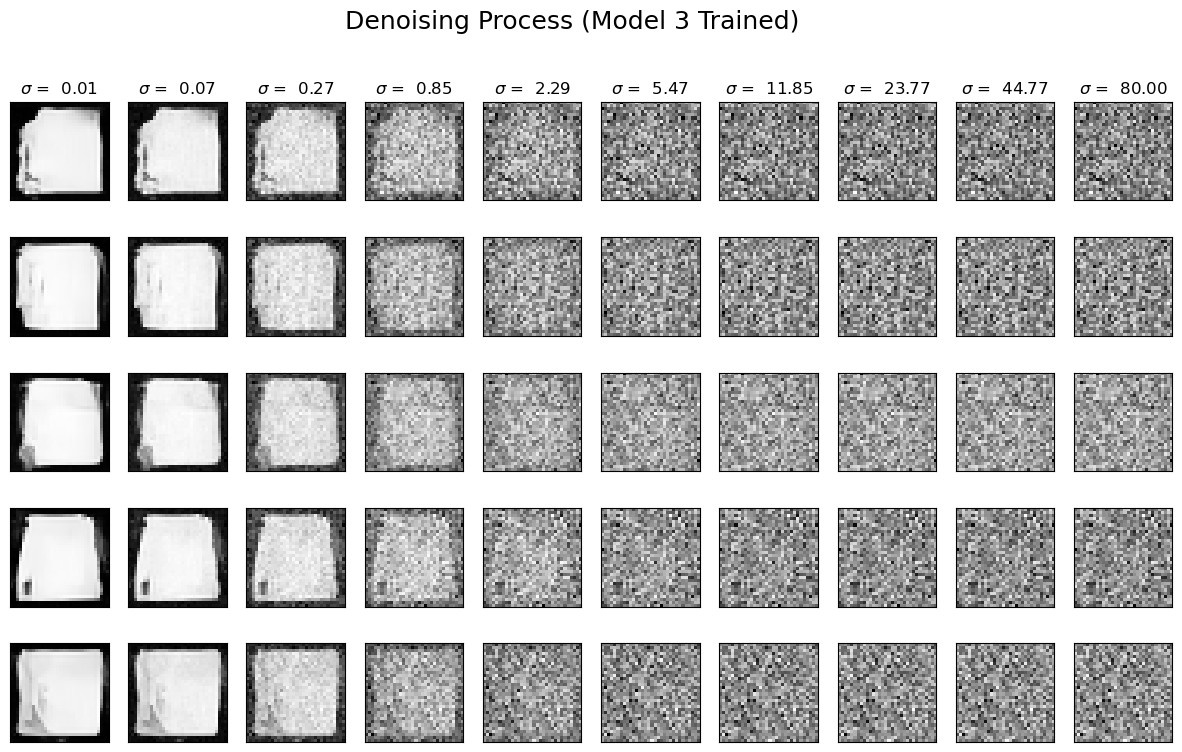

In [19]:
# plt.plot(train_loss, label="Train. Loss")
# plt.plot(val_loss, label="Val. Loss")
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
print(f"FID: {get_fid(100, sigmas, D, device): .1f}")
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model3", plot_title="Denoising Process (Model 3 Trained)")